# Face Hiding Workshop Practice

For more information about the OpenVINO Inference Engine Python API, see the [official documentation](https://docs.openvinotoolkit.org/latest/ie_python_api/annotated.html).

## Step 0. Preparation.

First of all we need to install requirements fo this workshop - packages like `numpy` to work with tensors and IPython to show a video in the notebook

In [ ]:
!pip3 install -r requirements.txt

The next step of the preparation is import needed packages

In [77]:
# Import OpenCV for work with a video and images
import cv2

# Import numpy to work with tensors
import numpy as np

import IPython

In [2]:
# Import OpenVINO Inference Engine
from openvino.inference_engine import get_version, IECore

# Check the version of Inference Engine
print(f'OpenVINO Inference Engine version is {get_version()}')

OpenVINO Inference Engine version is 2022.1.0-4151-d7e97ee2e40


Now we set some constants. This is paths to input and result videos and the model files.

In [43]:
from pathlib import Path

# Contains all data for the workshop
WORKSHOP_DATA_PATH = Path('data')

# Contains the model for the workshop
WORKSHOP_MODEL_PATH = WORKSHOP_DATA_PATH / 'models'

# Path to the Inference Engine model
FACE_DETECTION_MODEL_PATH_XML = WORKSHOP_MODEL_PATH / 'face-detection-adas-0001.xml'
FACE_DETECTION_MODEL_PATH_BIN = WORKSHOP_MODEL_PATH / 'face-detection-adas-0001.bin'

# Device which we will use 
DEVICE = 'CPU'

INPUT_IMAGE = str(WORKSHOP_DATA_PATH / 'input_image.jpg')

INPUT_VIDEO = str(WORKSHOP_DATA_PATH / 'input.mp4')
OUTPUT_VIDEO = str(WORKSHOP_DATA_PATH / 'output.MP4')

### Step 1: Create an instance of the OpenVINO Inference Engine `IECore` class
This class represents an Inference Engine entity 
and allows you to manipulate plugins using unified interfaces. 

In [4]:
ie_core = IECore()

### Step 2: Read the prepared model

To inference a model you need to read the model from the file usinf the instance of `IECore` class.
Use the `read_network` method for this. The method has two parameters: 
 1. path to the .xml file of the model 
 2. path to the .bin file of the model

In [36]:
network = ie_core.read_network(FACE_DETECTION_MODEL_PATH_XML, weights=FACE_DETECTION_MODEL_PATH_BIN)

### Step 3: Get the name of the input layer of the model

To infer a model, you need to know input layers of the model.
The object `face_detection_network` contains information about inputs of the network in a property `input_info`,
which is a dictionary: key - name of the input layer, volume - representation of the input network.
In this case, you need to get the name and the blob of the input .`face_detection_input_name` should be a string, `face_detection_input_blob`  should be a `DataPtr`.

In [63]:
input_name = next(iter(network.input_info))
input_blob = network.input_info[input_name].input_data

print(f'Name of the network input layer is "{input_name}"')

Name of the network input layer is "data"


### Step 4: Get shape (dimensions) of the input layer of the network

* n - number of batches
* c - number of input image channels (usualy 3 - R, G and B) 
* h - height
* w - width

In [40]:
input_shape = input_blob.shape

print(f'Input shape of the network is {input_shape}')

Input shape of the network is [1, 3, 384, 672]


In [65]:
output_blob_name = next(iter(network.outputs))

print(f'Name of the network output layer is "{output_blob_name}"')

Name of the network output layer is "detection_out"


### Step 5: Load the network to a device

The class `IECore` has a special function called `load_network`, which loads a network to a device.
This function prepares the network for the first inference on the device 
and returns an instance of the network prepared for an inference (execution). 
This function has many parameters, but in this case, you need to know only about two of them:
* `network` - instance of `IENetwork`, reterned from `read_network`
* `device_name` - string, contains a device name to infer a model on: CPU, GPU and so on.

In [34]:
network_loaded_to_device = ie_core.load_network(network, DEVICE)

## Step 6: Read image from a file 

In [111]:
input_frame = cv2.imread(INPUT_IMAGE)

## Step 7: Pre-processing of input image 
The function to prepare readed image for inference

In [112]:
def pre_processing(input_frame: np.ndarray, network_input_shape: np.ndarray) -> np.ndarray:
    
    _, _, input_layer_height, input_layer_width = network_input_shape
    
    # Resize the frame to the network input 
    resized_frame = cv2.resize(input_frame, (input_layer_width, input_layer_height))
    
    # Change the data layout from HWC to CHW
    transposed_frame = resized_frame.transpose((2, 0, 1)) 
    
    # Reshape the frame to the network input 
    reshaped_frame = transposed_frame.reshape(network_input_shape)
    
    return reshaped_frame

prepared_frame = pre_processing(input_frame, input_shape)

## Step 8: Inference

In [113]:
inference_result = face_detection_loaded_to_device.infer({
        input_name: prepared_frame
})

inference_result = inference_result[output_blob_name]

## Step 9: Process inference results

In [114]:
def pixelize_region(region: np.ndarray) -> np.ndarray:
    height, width = region.shape[:2]
    pixels_count = 16
    temp = cv2.resize(region, (pixels_count, pixels_count), interpolation=cv2.INTER_LINEAR)
    return cv2.resize(temp, (width, height), interpolation=cv2.INTER_NEAREST)

In [115]:
for detected_face in inference_result[0][0]:
    confidence =  detected_face[2]
    if confidence < 0.5:
        continue
    frame_h, frame_w = input_frame.shape[:2]
    
    xmin = int(detected_face[3]*frame_w)
    ymin = int(detected_face[4]*frame_h)

    xmax = int(detected_face[5]*frame_w)
    ymax = int(detected_face[6]*frame_h)
    
    w = xmax - xmin
    h = ymax - ymin
    
    face = input_frame[ymin:ymax, xmin:xmax]
    input_frame[ymin:ymax, xmin:xmax] = pixelize_region(face)
    # Get confidence for a discovered object
    confidence = round(confidence * 100, 1)
    
    # Draw a box and a label
    color = (0, 255, 0)
    
    # Create the title of an object
    text = f'{confidence}%'

    # Put the title to a frame
    cv2.putText(input_frame, text, (xmin, ymin - 7), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2)


## Step 10: Show the result

In [116]:
def show_images(image: np.ndarray):
    _,ret = cv2.imencode('.jpg', image) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

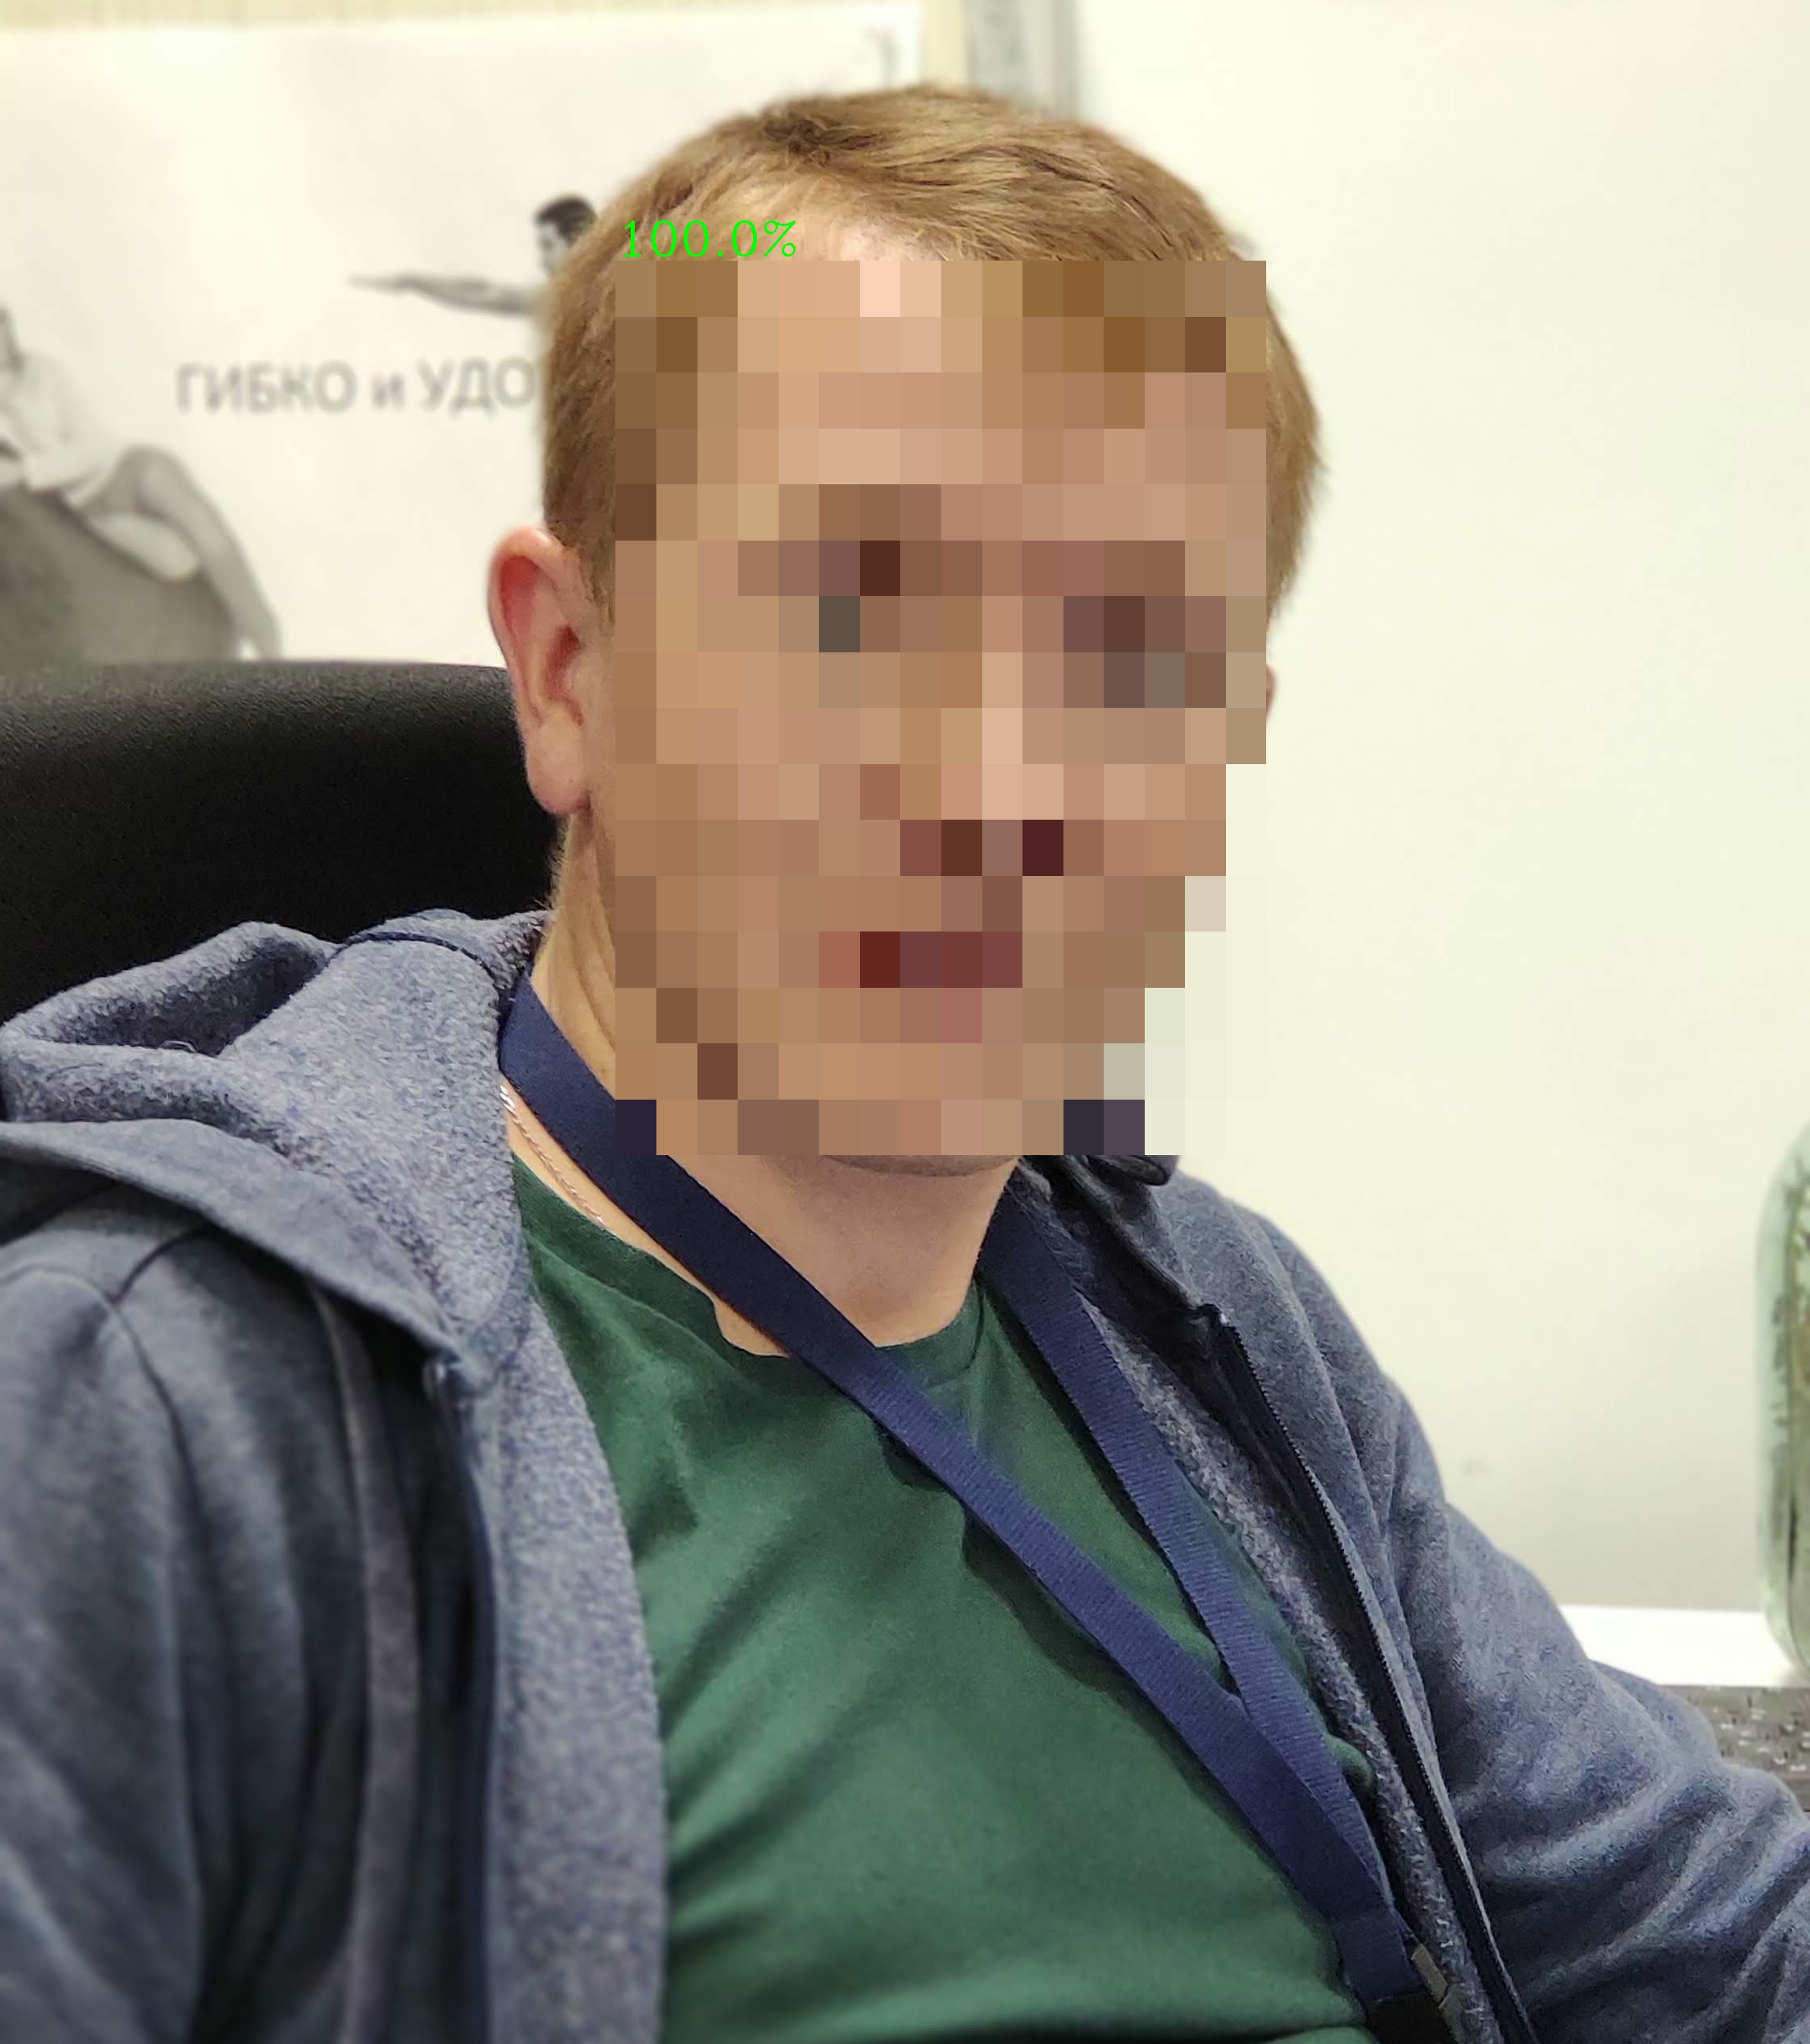

In [117]:
show_images(input_frame)

# Practice 1. Blure faces on a video 

## Create an IECore Instance 

In [92]:
ie_core = IECore()

## Read the network

In [93]:
face_detection_network = ie_core.read_network(FACE_DETECTION_MODEL_PATH_XML, weights=FACE_DETECTION_MODEL_PATH_BIN)

## Get name of network input

In [94]:
face_detection_input_name = next(iter(face_detection_network.input_info))
face_detection_input_blob = face_detection_network.input_info[face_detection_input_name].input_data

print(f'Name of the network input layer is "{face_detection_input_name}"')

Name of the network input layer is "data"


## Get shape (dimensions) of the input layer of the network

* n - number of batches
* c - number of input image channels (usualy 3 - R, G and B) 
* h - height
* w - width

In [95]:
face_detection_input_shape = face_detection_input_blob.shape

print(f'Input shape of the network is {face_detection_input_shape}')

Input shape of the network is [1, 3, 384, 672]


In [96]:
face_detection_output_blob_name = next(iter(face_detection_network.outputs))

print(f'Name of the network output layer is "{face_detection_output_blob_name}"')

Name of the network output layer is "detection_out"


## Load the network to a device

The class `IECore` has a special function called `load_network`, which loads a network to a device.
This function prepares the network for the first inference on the device 
and returns an instance of the network prepared for an inference (execution). 
This function has many parameters, but in this case, you need to know only about two of them:
* `network` - instance of `IENetwork`, reterned from `read_network`
* `device_name` - string, contains a device name to infer a model on: CPU, GPU and so on.

In [97]:
face_detection_loaded_to_device = ie_core.load_network(face_detection_network, DEVICE)

### Step 5: Open the input video

In [128]:
input_video_stream = cv2.VideoCapture(INPUT_VIDEO)

In [131]:
from IPython.display import HTML

# Show a source video
HTML(f"""<video width="600" height="400" controls><source src="{INPUT_VIDEO}" type="video/mp4"></video>""")

In [98]:
def face_detection_inference(input_frame: np.ndarray) -> np.ndarray:
    feed_dict = {
        face_detection_input_name: input_frame
    }
    
    # All is ready for the main thing - inference!
    # You have read and loaded the network to the device, prepared input data and now you are ready to infer.
    
    # To start an inference, call the `infer` function of the `face_detection_loaded_to_device` variable. 
    # We must set input data (a dictionary).
    inference_result = face_detection_loaded_to_device.infer(feed_dict)
    
    # Great! The `inference_result` variable contains output data after inference of the network.
    # `inference_result` is a dictionary, 
    #  where key is the name of the output name, 
    #        value is data from the blob.
    
    return inference_result[face_detection_blob]

In [130]:
def post_processing_face_detection_inference_result(original_frame: np.ndarray, detected_face: np.ndarray):       
    
    # The inference result contains 7 items
    confidence =  detected_face[2]
        
    if confidence < 0.5:
        return
    
    frame_h, frame_w = original_frame.shape[:2]
    
    xmin = int(detected_face[3]*frame_w)
    ymin = int(detected_face[4]*frame_h)

    xmax = int(detected_face[5]*frame_w)
    ymax = int(detected_face[6]*frame_h)
    
    w = xmax - xmin
    h = ymax - ymin
    
    face = original_frame[ymin:ymax, xmin:xmax]
    original_frame[ymin:ymax, xmin:xmax] = pixelize_region(face)
    
    
    # Get confidence for a discovered object
    confidence = round(confidence * 100, 1)
    
    # Draw a box and a label
    color = (0, 255, 0)
    
    # Create the title of an object
    text = f'{confidence}%'

    # Put the title to a frame
    cv2.putText(original_frame, text, (xmin, ymin - 7), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2)

### Step 9: Prepare output video stream

In [135]:
def prapare_out_video_stream(input_video_stream: cv2.VideoCapture, output_video_file_path: str) -> cv2.VideoWriter:
    width  = int(input_video_stream.get(3))
    height = int(input_video_stream.get(4))
    video_writer = cv2.VideoWriter(output_video_file_path, cv2.VideoWriter_fourcc(*'avc1'), 20, (width, height))
    return video_writer

In [132]:
# Create Output video stream
output_video_stream = prapare_out_video_stream(input_video_stream, OUTPUT_VIDEO)

# Get input height and width
input_frame_width = int(input_video_stream.get(3))   # float `width`
input_frame_height = int(input_video_stream.get(4))  # float `height`

### Step 10: Loop over frames in the input video

In [133]:
while input_video_stream.isOpened():
    # Read the next frame from the intput video 
    ret, frame = input_video_stream.read()
    # Check if the video is over
    if not ret:
        # Exit from the loop if the video is over
        break 
    
    # Prepare frame for inference
    in_frame = pre_processing(frame, face_detection_shape)
    
    
    inference_result = face_detection_inference(in_frame)
    
    for detected_face in inference_result[0][0]:
        post_processing_face_detection_inference_result(frame, detected_face)
    
    # Write the resulting frame to the output stream
    output_video_stream.write(frame)
    
input_video_stream.release()
# Save the resulting video
output_video_stream.release()

In [134]:
from IPython.display import HTML

# Show a source video
HTML(f"""<video width="600" height="400" controls><source src="{OUTPUT_VIDEO}" type="video/mp4"></video>""")

Do you see boxes in the video? 
If yes, you did all right!
**Good Work!** 

## Section 16: Practice (Part 2)

What is the next step? Often from neural networks build pipelines. It is to use the results of the first neural network as an input for the next neural network. 
Let's try to build a pipeline from two networks:  first is finds a person on the video and the next to recognize the emotions of this person

We have already run the first network. And find the person on the video.
The next step is to find a network for emotion recognition.
There is a good neural network in the [OpenModelZOO](https://docs.openvinotoolkit.org/2019_R1/_docs_Pre_Trained_Models.html) - [emotions-recognition-retail-0003 network](https://docs.openvinotoolkit.org/2019_R1/_emotions_recognition_retail_0003_description_emotions_recognition_retail_0003.html)

### Step 1: Download emotions-recognition-retail-0003 network
Run the Model Downloader eith needed arguments to download the emotions-recognition-retail-0003 network:

In [34]:
!python3 /opt/intel/openvino_2021/deployment_tools/open_model_zoo/tools/downloader/downloader.py --name emotions-recognition-retail-0003 --precision FP16 --output_dir data/model
!mv data/model/intel/emotions-recognition-retail-0003/FP16/emotions-recognition-retail-0003.* data/models/

################|| Downloading emotions-recognition-retail-0003 ||################

========== Downloading data/model/intel/emotions-recognition-retail-0003/FP16/emotions-recognition-retail-0003.xml
... 100%, 39 KB, 291 KB/s, 0 seconds passed

========== Downloading data/model/intel/emotions-recognition-retail-0003/FP16/emotions-recognition-retail-0003.bin
... 100%, 4848 KB, 4297 KB/s, 1 seconds passed



This mode already is in OpenVINO format and you do not need to convert it.

After downloading the model you can use it:

### Step 2: Read the prepared model
The IENetwork class is designed to work with a model in the Inference Engine. This class contains information about the network model read from the Intermediate Representation and allows you to manipulate some model parameters such as layers affinity and output layers.

You need to create an instance of the IENetwork class. A constructor of this class has two parameters:

path to the .xml file of the model
path to the .bin file of the model

In [80]:
emotion_recognition_network = ie_core.read_network('data/models/emotions-recognition-retail-0003.xml', 'data/models/emotions-recognition-retail-0003.bin')

### Step 3: Load the network to a device

Use the instance of `IECore`.
The class `IECore` has a special function called `load_network`, which loads a network to a device.
This function prepares the network for the first inference on the device 
and returns an instance of the network prepared for an inference (execution). 
This function has many parameters, but in this case, you need to know only about two of them:
* `network` - instance of `IENetwork`
* `device_name` - string, contains a device name to infer a model on: CPU, GPU and so on.

In [81]:
emotion_recognition_network_loaded_on_device = ie_core.load_network(emotion_recognition_network, 'CPU')

### Step 4: Open the input video

In [82]:
input_video_stream = cv2.VideoCapture(INPUT_VIDEO)

### Step 5: Create an output video stream

In [83]:
output_video_stream = prapare_out_video_stream(input_video_stream, OUTPUT_VIDEO)

In [84]:
emotion_recognition_input_layer = next(iter(emotion_recognition_network.input_info))
emotion_recognition_input_blob = emotion_recognition_network.input_info[emotion_recognition_input_layer].input_data

print(f'Input layer of the emotions-recognition-retail-0003 is {emotion_recognition_input_layer}')

Input layer of the emotions-recognition-retail-0003 is data


In [85]:
emotion_recognition_batch, emotion_recognition_channels, emotion_recognition_input_layer_h, emotion_recognition_input_layer_w = emotion_recognition_input_blob.shape

print(f'Input shape of the RetinaFace is [{emotion_recognition_batch}, {emotion_recognition_channels}, {emotion_recognition_input_layer_h}, {emotion_recognition_input_layer_w}]')

Input shape of the RetinaFace is [1, 3, 64, 64]


In [86]:
emotion_recognition_output_layer = next(iter(emotion_recognition_network.outputs))

### Step 6: Prepare a frame and run inference

In [87]:
def emotion_infer(face):
    # Resize the frame to the network input
    resized_frame = cv2.resize(face, (emotion_recognition_input_layer_w, emotion_recognition_input_layer_h))
    
    # Change the data layout from HWC to CHW
    transposed_frame = resized_frame.transpose((2, 0, 1))  
    
    # Reshape the frame to the network input 
    reshaped_frame = transposed_frame.reshape((emotion_recognition_batch, emotion_recognition_channels, emotion_recognition_input_layer_h, emotion_recognition_input_layer_w))

    # Run the inference how you did it early
    inference_results = emotion_recognition_network_loaded_on_device.infer({
        emotion_recognition_input_layer: reshaped_frame
    })
    # For understanding what is the result of inference this model, check documentation 
    # https://docs.openvinotoolkit.org/latest/_models_intel_emotions_recognition_retail_0003_description_emotions_recognition_retail_0003.html
    return inference_results[emotion_recognition_output_layer]

### Step 16: Drow boxes and emotions in a frame

In [88]:
def get_smile_by_index(emotion_inference_result: np.ndarray) -> np.ndarray:
    emotions = ['neutral', 'happy', 'sad', 'surprise', 'anger']
    emotion_index = np.argmax(emotion_inference_result.flatten()) 
    smile_path = f'./data/{emotions[emotion_index]}.png'
    return cv2.imread(smile_path)

In [92]:
def emotion_recognition_inference_postpprocess(original_frame, detected_face, emotion_result, x_limits, y_limits):
    smile = get_smile_by_index(emotion_result)
    # Put the title to a frame
    w = x_limits[1] - x_limits[0]
    h = y_limits[1] - y_limits[0]
    print(w, h)
    resized_smile = cv2.resize(smile, (w, h))
    
    original_frame[y_limits[0]:y_limits[1], x_limits[0]:x_limits[1]] = resized_smile

### Step 17: Loop over frames in the input video

In [93]:
while input_video_stream.isOpened():
    
    # Read the next frame from the intput video 
    ret, original_frame = input_video_stream.read()
    # Check if the video is over
    if not ret:
        # Exit from the loop if the video is over
        break 
    face_detection_frame = pre_processing(original_frame, face_detection_shape)
    face_detection_inferece_result = face_detection_inference(face_detection_frame)
    frame_h, frame_w = original_frame.shape[:2]
    for detected_face in face_detection_inferece_result[0][0]:
        if detected_face[2] < 0.5:
            continue
        # Step 13: Get the confidence for a discovered object
        xmin = int(detected_face[3]*frame_w)
        ymin = int(detected_face[4]*frame_h)

        xmax = int(detected_face[5]*frame_w)
        ymax = int(detected_face[6]*frame_h)
        
        emotion_recognition_frame = original_frame[ymin:ymax, xmin:xmax]
    
        # Get height and width of the frame
        emotion_recognition_result = emotion_infer(emotion_recognition_frame)
        emotion_recognition_inference_postpprocess(original_frame, detected_face, emotion_recognition_result, (xmin, xmax), (ymin, ymax))
        # Write the resulting frame to the output stream
    
    output_video_stream.write(original_frame)
    
input_video_stream.release()
# Save the resulting video
output_video_stream.release()

435 571


error: OpenCV(4.5.3-openvino) ../opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


Now the person (Artyom) on the resulting video will be detected with emotion:

In [ ]:
# Show a source video
HTML(f"""<video width="600" height="400" controls><source src="{OUTPUT_VIDEO}" type="video/mp4"></video>""")